# 1. Libraries and Data Load

In [1]:
import numpy as np
import pandas as pd
import os
import math

from scipy import stats #Analysis 
from scipy.stats import norm 
from pickle import dump

import missingno as msno
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import rcParams
%matplotlib inline

from sklearn.preprocessing import LabelEncoder
import category_encoders as ce
from sklearn.decomposition import PCA

In [2]:
# # pandas option 설정 하는 코드
# # monthly_gain의 경우 부동소수점으로 나타나서 보기 어려울땐 윗 줄의 주석을 제거하고 아래에 주석을 추가하고
# # 다시 원래대로 돌리고 싶다면 아래에 주석제거, 위 코드에 주석추가
# pd.options.display.float_format = '{:.2f}'.format
# #pd.reset_option('display.float_format')

In [3]:
path = "./Dataset/"

data = pd.read_csv(path+"train.csv" ,parse_dates=['TIMESTAMP'])  # 애초에 datatime 유형의 데이터를 읽어 올 때부터 형변환하기

# original data -> data
data

,PRODUCT_ID,Y_Class,Y_Quality,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TRAIN_000,1,0.533433,2022-06-13 05:14:00,T050304,A_31,NaN,NaN,NaN,NaN,...,39.34,40.89,32.56,34.09,77.77,NaN,NaN,NaN,NaN,NaN
1,TRAIN_001,2,0.541819,2022-06-13 05:22:00,T050307,A_31,NaN,NaN,NaN,NaN,...,38.89,42.82,43.92,35.34,72.55,NaN,NaN,NaN,NaN,NaN
2,TRAIN_002,1,0.531267,2022-06-13 05:30:00,T050304,A_31,NaN,NaN,NaN,NaN,...,39.19,36.65,42.47,36.53,78.35,NaN,NaN,NaN,NaN,NaN
3,TRAIN_003,2,0.537325,2022-06-13 05:39:00,T050307,A_31,NaN,NaN,NaN,NaN,...,37.74,39.17,52.17,30.58,71.78,NaN,NaN,NaN,NaN,NaN
4,TRAIN_004,1,0.531590,2022-06-13 05:47:00,T050304,A_31,NaN,NaN,NaN,NaN,...,38.70,41.89,46.93,33.09,76.97,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,TRAIN_593,1,0.526546,2022-09-08 14:30:00,T100306,T_31,2.0,95.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
594,TRAIN_594,0,0.524022,2022-09-08 22:38:00,T050304,A_31,NaN,NaN,NaN,NaN,...,49.47,53.07,50.89,55.10,66.49,1.0,NaN,NaN,NaN,NaN
595,TRAIN_595,0,0.521289,2022-09-08 22:47:00,T050304,A_31,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
596,TRAIN_596,1,0.531375,2022-09-08 14:38:00,T100304,O_31,40.0,94.0,0.0,45.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


# 2. Preprocessing

598 rows × 2,881 columns

- **Identification variable (1)**
    - PRODUCT_ID: 제품 고유의 ID 
- **Categorical variable (2)**
    - LINE: 제품이 들어간 공정 LINE 종류 (6)
        - 'T050304', 'T050307', 'T100304', 'T100306', 'T010306', 'T010305'
    - PRODUCT_CODE: 제품의 CODE 번호 (3) 
        - 'A_31', 'T_31', 'O_31'
- **Numerical variable (3)**
    - Y_Quality: 제품 품질 관련 정량적 수치 
    - TIMESTAMP: 제품이 공정에 들어간 시간 
    - X(1~2875): 공정 과정에서 추출되어 비식별화된 변수
- **Y variable (1)**
    - Y_Class: 제품 품질 상태 
        - multi-class classification 
        - 0: 적정 기준 미달 (부적합) 1: 적정 2: 적정 기준 초과 (부적합)
        - 1:8303, 0:6697

In [35]:
# 원본 data와 따로 관리 -> original data = data, preprocessed data = processed_data 
# Feature Drop 
# 'PRODUCT_ID'
processed_data = data.drop(['PRODUCT_ID', 'Y_Quality'], axis=1).copy()

In [36]:
# Handling Null Values within 'X' Columns
processed_data = processed_data.fillna(0)
processed_data.head()

,Y_Class,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,1,2022-06-13 05:14:00,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,39.34,40.89,32.56,34.09,77.77,0.0,0.0,0.0,0.0,0.0
1,2,2022-06-13 05:22:00,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,38.89,42.82,43.92,35.34,72.55,0.0,0.0,0.0,0.0,0.0
2,1,2022-06-13 05:30:00,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,39.19,36.65,42.47,36.53,78.35,0.0,0.0,0.0,0.0,0.0
3,2,2022-06-13 05:39:00,T050307,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,37.74,39.17,52.17,30.58,71.78,0.0,0.0,0.0,0.0,0.0
4,1,2022-06-13 05:47:00,T050304,A_31,0.0,0.0,0.0,0.0,0.0,0.0,...,38.70,41.89,46.93,33.09,76.97,0.0,0.0,0.0,0.0,0.0


In [37]:
# Handling 'X' columns group by 'PRODUCT_CODE' & 'LINE' for PCA
def processed_pca(pca, data):
    pca_data = pca.fit_transform(data.drop(['PRODUCT_CODE', 'LINE', 'TIMESTAMP', 'Y_Class'], axis=1))
    pca_data = pd.DataFrame(pca_data)
    processed_data = pd.concat([data.iloc[:, :4].reset_index(drop=True), pca_data], axis=1)
    return processed_data

groups = processed_data.groupby(['PRODUCT_CODE', 'LINE'])
groups_df = []
for (k1, k2), group in groups:
    df = pd.DataFrame(group)
    groups_df.append(df)

In [38]:
# PCA A 305 & 306
pcaA1 = PCA(n_components=4)
groups_A1 = processed_pca(pcaA1, pd.concat([groups_df[0], groups_df[1]]))

# PCA A 304 & 307
pcaA2 = PCA(n_components=4)
groups_A2 = processed_pca(pcaA2, pd.concat([groups_df[2], groups_df[3]]))

# # PCA O 304 & 306
# pcaO = PCA(n_components=4)
# groups_O = processed_pca(pcaO, pd.concat([groups_df[4], groups_df[5]]))

# PCA O & T 304 & 306
pcaOT = PCA(n_components=4)
groups_OT = processed_pca(pcaOT, pd.concat([groups_df[4], groups_df[5], groups_df[6], groups_df[7]]))

# Concat all  of pca dataset
processed_data = pd.concat([groups_A1, groups_A2, groups_OT]).reset_index(drop=True)
processed_data.head()

,Y_Class,TIMESTAMP,LINE,PRODUCT_CODE,0,1,2,3
0,0,2022-06-19 20:26:00,T010305,A_31,3.910744e+06,-1.250950e+06,-79811.880412,-6869.623954
1,1,2022-06-21 07:14:00,T010305,A_31,-4.495475e+06,-9.488846e+04,-56454.851885,39466.883689
2,1,2022-06-22 04:45:00,T010305,A_31,-4.887482e+06,-4.108744e+04,-55821.223512,41253.211622
3,1,2022-06-22 12:26:00,T010305,A_31,-2.949319e+05,-6.717513e+05,-68268.870047,17395.888188
4,1,2022-06-22 12:34:00,T010305,A_31,-2.111366e+05,-6.832614e+05,-68483.297746,16967.821129


In [39]:
# Encoding for Categorical Variables
# Label Encdoing 
# le_line = LabelEncoder()
# processed_data['LINE'] = le_line.fit_transform(list(processed_data['LINE']))   
# print(le_line.classes_)

# le_pc = LabelEncoder()
# processed_data['PRODUCT_CODE'] = le_pc.fit_transform(list(processed_data['PRODUCT_CODE']))   
# print(le_pc.classes_)

# Binary Encoding 
encoder = ce.BinaryEncoder(cols=["LINE", "PRODUCT_CODE"])
df = encoder.fit_transform(processed_data[["LINE", "PRODUCT_CODE"]])

processed_data = pd.concat([processed_data, df], axis=1)
processed_data = processed_data.drop(["LINE", "PRODUCT_CODE"], axis=1)

In [41]:
# Handling TIMESTAMP feature 
processed_data['month'] = processed_data['TIMESTAMP'].dt.month
processed_data['day'] = processed_data['TIMESTAMP'].dt.day
processed_data['hour'] = processed_data['TIMESTAMP'].dt.hour
processed_data['minute'] = processed_data['TIMESTAMP'].dt.minute
processed_data = processed_data.drop(['TIMESTAMP'], axis=1)

In [42]:
# Check the status of processed data
processed_data

,Y_Class,0,1,2,3,LINE_0,LINE_1,LINE_2,PRODUCT_CODE_0,PRODUCT_CODE_1,month,day,hour,minute
0,0,3.910744e+06,-1.250950e+06,-79811.880412,-6869.623954,0,0,1,0,1,6,19,20,26
1,1,-4.495475e+06,-9.488846e+04,-56454.851885,39466.883689,0,0,1,0,1,6,21,7,14
2,1,-4.887482e+06,-4.108744e+04,-55821.223512,41253.211622,0,0,1,0,1,6,22,4,45
3,1,-2.949319e+05,-6.717513e+05,-68268.870047,17395.888188,0,0,1,0,1,6,22,12,26
4,1,-2.111366e+05,-6.832614e+05,-68483.297746,16967.821129,0,0,1,0,1,6,22,12,34
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
593,1,-9.581521e+03,-1.174714e+04,1190.626711,-81.064723,1,1,0,1,1,9,6,17,51
594,1,-9.598712e+03,-1.170816e+04,1210.457750,-78.943797,1,1,0,1,1,9,6,18,0
595,1,-9.844226e+03,-1.114576e+04,1499.511801,-47.959669,1,1,0,1,1,9,7,1,1
596,1,-9.860650e+03,-1.110790e+04,1519.073155,-45.954497,1,1,0,1,1,9,7,1,9


# 3. Data Split 
split data as train/valid

In [43]:
# 전처리된 data와 따로 관리 -> preprocessed data = procssed_data, input data = input_data 
input_data = processed_data.copy()
input_data_y = input_data['Y_Class'].copy()
input_data_X = input_data.drop(['Y_Class'], axis=1)
print(len(input_data_X))
print(len(input_data_y))

598
598


In [44]:
# train/ valid data 로 split 
from sklearn.model_selection import train_test_split, StratifiedKFold
tr_val_X, test_X, tr_val_y, test_y = train_test_split(
    input_data_X, 
    input_data_y, 
    test_size = 0.2, 
    stratify = input_data_y,
    random_state = 2023,
    shuffle=True
)

train_data = pd.concat([tr_val_X, tr_val_y], axis=1).reset_index(drop=True)
test_data = pd.concat([test_X, test_y], axis=1).reset_index(drop=True)

print(len(train_data))
print(len(test_data))

478
120


# 4. Modeling - XGB, LGBM 

In [45]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import AdaBoostClassifier
from xgboost import XGBClassifier
from xgboost import plot_importance
from lightgbm import LGBMClassifier
from lightgbm import plot_importance 
from catboost import CatBoostClassifier
# Learning task parameters
# multi:softmax : softmax를 이용한 다중 클래스 분류 
# multi:softptob : softmax를 이용한 다중 클래스에 대한 예상 확률 반환 
# mlogloss : multiclass logloss 
from keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score
from pandas import MultiIndex, Int64Index

C:\Users\Hyeongbin\AppData\Local\Temp\ipykernel_7784\599317148.py:14: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


**RandomForest**

5 fold < 10 fold

fold가 증가할 수록 0을 맞출 때  Recall - Precision 격차가 커짐 => F1 score 자체는 동일 

In [52]:
model_rf = RandomForestClassifier(random_state=2023)

In [53]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=10)
cv_accuracy = []
n_iter =0

for train_index, valid_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    train_X, valid_X = tr_val_X.iloc[train_index], tr_val_X.iloc[valid_index]
    train_y, valid_y = tr_val_y.iloc[train_index], tr_val_y.iloc[valid_index]
    
    model_rf.fit(train_X, train_y)
    pred = model_rf.predict(valid_X)
    n_iter += 1
    
    accuracy = np.round(f1_score(valid_y, pred, average='macro'), 4) # 소수점 4자리 반올림
    train_size = train_X.shape[0]
    valid_size = valid_X.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, valid_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,valid_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.7111,  학습 데이터 크기 : 430,  검증 데이터 크기 : 48
#1 검증 세트 인덱스 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 37 39 42 43 44 45 46 48 50 51 52 54]

#2 교차 검증 정확도 : 0.5942,  학습 데이터 크기 : 430,  검증 데이터 크기 : 48
#2 검증 세트 인덱스 : [ 36  38  40  41  47  49  53  55  56  57  58  59  60  61  62  63  64  65
  67  68  69  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  93  95  96  97 103 111]

#3 교차 검증 정확도 : 0.613,  학습 데이터 크기 : 430,  검증 데이터 크기 : 48
#3 검증 세트 인덱스 : [ 66  70  92  94  98  99 100 101 102 104 105 106 107 108 109 110 112 114
 115 116 117 119 121 122 123 124 126 128 129 130 131 132 133 134 135 136
 137 138 139 140 142 143 144 146 151 155 156 157]

#4 교차 검증 정확도 : 0.6424,  학습 데이터 크기 : 430,  검증 데이터 크기 : 48
#4 검증 세트 인덱스 : [113 118 120 125 127 141 145 147 148 149 150 152 153 154 158 159 160 162
 163 164 166 167 168 169 170 171 173 174 175 176 177 179 180 182 185 186
 187 188 190 191 192 193

In [54]:
pred_rf = model_rf.predict(test_X)
print(classification_report(test_y, pred_rf))

              precision    recall  f1-score   support

           0       0.75      0.53      0.62        17
           1       0.81      0.91      0.86        82
           2       0.67      0.48      0.56        21

    accuracy                           0.78       120
   macro avg       0.74      0.64      0.68       120
weighted avg       0.77      0.78      0.77       120



**XGB**

fold 5 < fold 10 

fold 증가 -> 0 을 맞출 확률이 높아지고 2를 맞출 확률이 떨어짐

In [58]:
model_xgb = XGBClassifier(
    eval_metric='mlogloss', use_label_encoder=False, random_state=2023)

In [59]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=15)
cv_accuracy = []
n_iter =0

for train_index, valid_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    train_X, valid_X = tr_val_X.iloc[train_index], tr_val_X.iloc[valid_index]
    train_y, valid_y = tr_val_y.iloc[train_index], tr_val_y.iloc[valid_index]
    
    model_xgb.fit(train_X, train_y)
    pred = model_xgb.predict(valid_X)
    n_iter += 1
    
    accuracy = np.round(f1_score(valid_y, pred, average='macro'), 4) # 소수점 4자리 반올림
    train_size = train_X.shape[0]
    valid_size = valid_X.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, valid_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,valid_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.7625,  학습 데이터 크기 : 446,  검증 데이터 크기 : 32
#1 검증 세트 인덱스 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 17 19 20 21 22 23 24 25
 26 27 28 29 30 32 34 35]

#2 교차 검증 정확도 : 0.7454,  학습 데이터 크기 : 446,  검증 데이터 크기 : 32
#2 검증 세트 인덱스 : [16 18 31 33 36 37 39 42 43 44 45 46 48 50 51 52 54 55 56 57 58 59 60 61
 62 63 64 65 67 68 72 75]

#3 교차 검증 정확도 : 0.4517,  학습 데이터 크기 : 446,  검증 데이터 크기 : 32
#3 검증 세트 인덱스 : [ 38  40  41  47  49  69  71  73  74  76  77  78  79  80  81  82  83  84
  85  86  87  88  89  90  91  93  95  96  97 103 111 131]

#4 교차 검증 정확도 : 0.5578,  학습 데이터 크기 : 446,  검증 데이터 크기 : 32
#4 검증 세트 인덱스 : [ 53  66  70  92  94  98  99 102 104 105 106 107 108 109 112 114 115 116
 117 119 121 122 123 124 126 128 129 133 139 146 151 155]

#5 교차 검증 정확도 : 0.5286,  학습 데이터 크기 : 446,  검증 데이터 크기 : 32
#5 검증 세트 인덱스 : [100 101 110 113 118 130 132 134 135 136 137 138 140 142 143 144 145 147
 148 149 150 152 154 156 157 158 159 160 162 169 173 174]

#6 교차 검증 정확도 : 0.642,  학습 데이터 크기 : 446,  검증

In [60]:
pred_xgb_prob = model_xgb.predict_proba(test_X)
pred_xgb = np.argmax(pred_xgb_prob, axis=1)

print(classification_report(test_y, pred_xgb))

              precision    recall  f1-score   support

           0       0.73      0.47      0.57        17
           1       0.80      0.90      0.85        82
           2       0.62      0.48      0.54        21

    accuracy                           0.77       120
   macro avg       0.72      0.62      0.65       120
weighted avg       0.76      0.77      0.75       120



**LGBM**

fold 5 < fold 10

In [68]:
model_lgbm = LGBMClassifier(random_state=2023)

In [69]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=10)
cv_accuracy = []
n_iter =0

for train_index, valid_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    train_X, valid_X = tr_val_X.iloc[train_index], tr_val_X.iloc[valid_index]
    train_y, valid_y = tr_val_y.iloc[train_index], tr_val_y.iloc[valid_index]
    
    model_lgbm.fit(train_X, train_y)
    pred = model_lgbm.predict(valid_X)
    n_iter += 1
    
    accuracy = np.round(f1_score(valid_y, pred, average='macro'), 4) # 소수점 4자리 반올림
    train_size = train_X.shape[0]
    valid_size = valid_X.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, valid_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,valid_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))


#1 교차 검증 정확도 : 0.7671,  학습 데이터 크기 : 430,  검증 데이터 크기 : 48
#1 검증 세트 인덱스 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 37 39 42 43 44 45 46 48 50 51 52 54]

#2 교차 검증 정확도 : 0.4745,  학습 데이터 크기 : 430,  검증 데이터 크기 : 48
#2 검증 세트 인덱스 : [ 36  38  40  41  47  49  53  55  56  57  58  59  60  61  62  63  64  65
  67  68  69  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85
  86  87  88  89  90  91  93  95  96  97 103 111]

#3 교차 검증 정확도 : 0.6634,  학습 데이터 크기 : 430,  검증 데이터 크기 : 48
#3 검증 세트 인덱스 : [ 66  70  92  94  98  99 100 101 102 104 105 106 107 108 109 110 112 114
 115 116 117 119 121 122 123 124 126 128 129 130 131 132 133 134 135 136
 137 138 139 140 142 143 144 146 151 155 156 157]

#4 교차 검증 정확도 : 0.472,  학습 데이터 크기 : 430,  검증 데이터 크기 : 48
#4 검증 세트 인덱스 : [113 118 120 125 127 141 145 147 148 149 150 152 153 154 158 159 160 162
 163 164 166 167 168 169 170 171 173 174 175 176 177 179 180 182 185 186
 187 188 190 191 192 193

In [70]:
pred_lgbm_prob = model_lgbm.predict_proba(test_X)
pred_lgbm = np.argmax(pred_lgbm_prob, axis=1)

print(classification_report(test_y, pred_lgbm))

              precision    recall  f1-score   support

           0       0.50      0.47      0.48        17
           1       0.81      0.87      0.84        82
           2       0.56      0.43      0.49        21

    accuracy                           0.73       120
   macro avg       0.62      0.59      0.60       120
weighted avg       0.72      0.73      0.72       120



**CAT**

fold 5 < fold 10

fold가 커질수록 0의 precision, recall 격차가 작아짐 

fold가 커질수록 2의 precision, recall 격차가 커짐 

In [71]:
# Categorical 범주에 적잡한 알고리즘 
# 수치형 변수가 많다면 lightGBM보다 학습 속도가느릴 수 있음 
cat_features = ['PRODUCT_CODE', 'LINE']
model_cat = CatBoostClassifier(
                               random_state=2023)

In [74]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score

kfold = StratifiedKFold(n_splits=10)
cv_accuracy = []
n_iter =0

for train_index, valid_index in kfold.split(tr_val_X, tr_val_y):  # feautres 데이터를 위에서 지정한 kfold 숫자로 분할
    train_X, valid_X = tr_val_X.iloc[train_index], tr_val_X.iloc[valid_index]
    train_y, valid_y = tr_val_y.iloc[train_index], tr_val_y.iloc[valid_index]
    
    model_cat.fit(train_X, train_y,
                  verbose = 100)
    pred = model_cat.predict(valid_X)
    n_iter += 1
    
    accuracy = np.round(f1_score(valid_y, pred, average='macro'), 4) # 소수점 4자리 반올림
    train_size = train_X.shape[0]
    valid_size = valid_X.shape[0]
    
    print('\n#{0} 교차 검증 정확도 : {1},  학습 데이터 크기 : {2},  검증 데이터 크기 : {3}'
          .format(n_iter, accuracy, train_size, valid_size))
    print('#{0} 검증 세트 인덱스 : {1}'.format(n_iter,valid_index))
    cv_accuracy.append(accuracy)
    
print('\n## 평균 검증 정확도:', np.mean(cv_accuracy))

Learning rate set to 0.075793
0:	learn: 1.0459986	total: 2.19ms	remaining: 2.19s
100:	learn: 0.4232025	total: 174ms	remaining: 1.55s
200:	learn: 0.2750748	total: 340ms	remaining: 1.35s
300:	learn: 0.1989103	total: 509ms	remaining: 1.18s
400:	learn: 0.1501871	total: 676ms	remaining: 1.01s
500:	learn: 0.1187206	total: 836ms	remaining: 832ms
600:	learn: 0.0974491	total: 1.01s	remaining: 669ms
700:	learn: 0.0809929	total: 1.2s	remaining: 511ms
800:	learn: 0.0681337	total: 1.36s	remaining: 338ms
900:	learn: 0.0593350	total: 1.52s	remaining: 168ms
999:	learn: 0.0520452	total: 1.7s	remaining: 0us

#1 교차 검증 정확도 : 0.7111,  학습 데이터 크기 : 430,  검증 데이터 크기 : 48
#1 검증 세트 인덱스 : [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 37 39 42 43 44 45 46 48 50 51 52 54]
Learning rate set to 0.075793
0:	learn: 1.0460715	total: 20.8ms	remaining: 20.8s
100:	learn: 0.4141551	total: 241ms	remaining: 2.15s
200:	learn: 0.2733472	total: 462ms	remaining: 1.83

900:	learn: 0.0586272	total: 1.65s	remaining: 182ms
999:	learn: 0.0517285	total: 1.83s	remaining: 0us

#10 교차 검증 정확도 : 0.6859,  학습 데이터 크기 : 431,  검증 데이터 크기 : 47
#10 검증 세트 인덱스 : [420 422 429 431 433 434 435 438 439 440 441 442 443 444 445 446 447 448
 449 450 451 452 453 454 455 456 457 458 459 460 461 462 463 464 465 466
 467 468 469 470 471 472 473 474 475 476 477]

## 평균 검증 정확도: 0.6020800000000001


In [75]:
pred_cat_prob = model_cat.predict_proba(test_X)
pred_cat = np.argmax(pred_cat_prob, axis=1)

print(classification_report(test_y, pred_cat))

              precision    recall  f1-score   support

           0       0.53      0.47      0.50        17
           1       0.80      0.89      0.84        82
           2       0.57      0.38      0.46        21

    accuracy                           0.74       120
   macro avg       0.64      0.58      0.60       120
weighted avg       0.72      0.74      0.73       120



<AxesSubplot:xlabel='importance', ylabel='feature'>

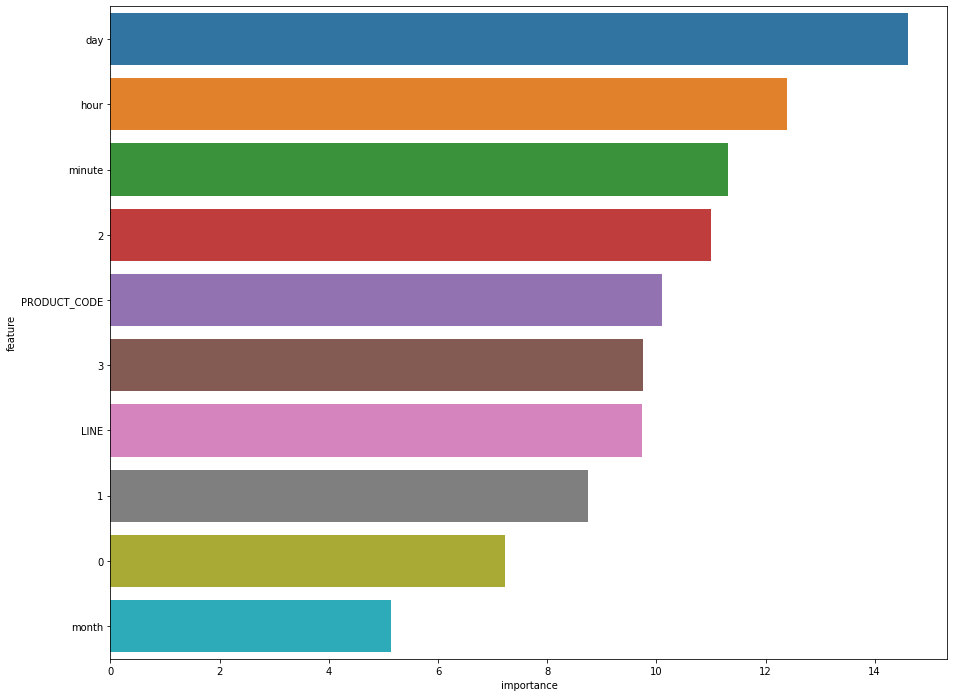

In [350]:
feature_importance_cat = pd.DataFrame(train_X.columns, columns=["feature"])
feature_importance_cat["importance"] = model_cat1.feature_importances_
feature_importance_cat = feature_importance_cat.sort_values(by=["importance"], ascending=False)

plt.figure(figsize = (15,12))
sns.barplot(data=feature_importance_cat, x="importance", y="feature")

# 5. Inference

In [399]:
test = pd.read_csv(path+"test.csv" ,parse_dates=['TIMESTAMP'])
test.head()

,PRODUCT_ID,TIMESTAMP,LINE,PRODUCT_CODE,X_1,X_2,X_3,X_4,X_5,X_6,...,X_2866,X_2867,X_2868,X_2869,X_2870,X_2871,X_2872,X_2873,X_2874,X_2875
0,TEST_000,2022-09-09 02:01:00,T100306,T_31,2.0,94.0,0.0,45.0,10.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,TEST_001,2022-09-09 02:09:00,T100304,T_31,2.0,93.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,TEST_002,2022-09-09 08:42:00,T100304,T_31,2.0,95.0,0.0,45.0,11.0,0.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,TEST_003,2022-09-09 10:56:00,T010305,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,TEST_004,2022-09-09 11:04:00,T010306,A_31,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [400]:
# Feature Drop 
# 'PRODUCT_ID'
processed_data = test.drop(['PRODUCT_ID'], axis=1).copy()

# Handling Null Values within 'X' Columns
processed_data = processed_data.fillna(0)

# Handling 'X' columns group by 'PRODUCT_CODE' & 'LINE' for PCA
groups = processed_data.groupby(['PRODUCT_CODE', 'LINE'])
groups_df = []
for (k1, k2), group in groups:
    df = pd.DataFrame(group)
    groups_df.append(df)
    
# PCA A 305 & 306, A 304 & 307, O 304 & 306, T 304 & 306
groups_A1 = processed_pca(pcaA1, pd.concat([groups_df[0], groups_df[1]]))
groups_A2 = processed_pca(pcaA2, pd.concat([groups_df[2], groups_df[3]]))
groups_O = processed_pca(pcaO,  pd.concat([groups_df[4], groups_df[5]]))
groups_T = processed_pca(pcaT, pd.concat([groups_df[6], groups_df[7]]))
processed_data = pd.concat([groups_A1, groups_A2, groups_O, groups_T]).reset_index(drop=True)

# Encoding for Categorical Variables
# Label Encdoing 
processed_data['LINE'] = le_line.transform(list(processed_data['LINE']))   
processed_data['PRODUCT_CODE'] = le_pc.transform(list(processed_data['PRODUCT_CODE']))

# Handling TIMESTAMP feature 
processed_data['month'] = processed_data['TIMESTAMP'].dt.month
processed_data['day'] = processed_data['TIMESTAMP'].dt.day
processed_data['hour'] = processed_data['TIMESTAMP'].dt.hour
processed_data['minute'] = processed_data['TIMESTAMP'].dt.minute
processed_data = processed_data.drop(['TIMESTAMP'], axis=1)

processed_data

,LINE,PRODUCT_CODE,0,1,2,3,month,day,hour,minute
0,0,0,5.118133e+06,196698.444731,-7946.205679,7436.702664,9,9,10,56
1,0,0,-1.714471e+06,-79793.789930,-61778.046767,156985.712995,9,9,19,43
2,0,0,-2.206786e+04,-112165.501513,-32706.051529,33799.524835,9,10,14,21
3,0,0,7.153530e+05,-15771.722278,-18454.896828,-31113.632074,9,11,13,8
4,0,0,3.212652e+06,-11707.067719,-9043.638694,-15265.188426,9,25,8,50
...,...,...,...,...,...,...,...,...,...,...
305,5,2,-3.195527e+04,-14971.647981,-5512.220139,720.556109,11,4,15,18
306,5,2,-3.243878e+04,-16091.940194,-5988.959748,790.114176,11,5,11,18
307,5,2,-3.259018e+04,-16442.366862,-6138.046404,811.533876,11,5,16,47
308,5,2,-3.272518e+04,-16754.993421,-6271.044465,831.181135,11,5,20,53


In [419]:
test = processed_data
pred_prob = model_cat.predict_proba(test)
pred = np.argmax(pred_prob, axis=1)

In [286]:
# 산술평균 앙상블 (cv10 + cv15)
test = processed_data
pred_list = []

score = model_cat1.predict_proba(test)
pred_list.append(score)

score = model_cat2.predict_proba(test)
pred_list.append(score)

pred_prob = np.mean(pred_list, axis=0)
pred = np.argmax(pred_prob, axis=1)

# 6. Submission

In [420]:
# 제출용 sample 파일을 불러옵니다.
submission = pd.read_csv(path + 'sample_submission.csv')
submission.head()

,PRODUCT_ID,Y_Class
0,TEST_000,0
1,TEST_001,0
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0


In [421]:
# 위에서 구한 예측값을 그대로 넣어줍니다.
submission['Y_Class'] = pd.DataFrame(pred)

# 데이터가 잘 들어갔는지 확인합니다.
submission

,PRODUCT_ID,Y_Class
0,TEST_000,1
1,TEST_001,1
2,TEST_002,0
3,TEST_003,0
4,TEST_004,0
...,...,...
305,TEST_305,1
306,TEST_306,1
307,TEST_307,1
308,TEST_308,1


In [422]:
submission['Y_Class'].value_counts()

1    275
0     28
2      7
Name: Y_Class, dtype: int64

In [298]:
import datetime
filename = datetime.datetime.now().strftime("%m%d_%H_%M_%S")
filename

'0213_15_42_41'

In [299]:
submission.to_csv(path+"{}.csv".format(filename), index=False)